In [1]:
import glob
from pathlib import Path

train_path = '../input/paddy-doctor-diseases-v2/train_images/'
test_path  = '../input/paddy-doctor-diseases-v2/test_images/'

print('train images')
for filepath in glob.glob(train_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")
    
print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")

# files = glob.glob(test_path + '/*')
# print(f"{len(files)} \t {Path(test_path).name}") 

train images
1561 	 tungro
613 	 yellow_stem_borer
1720 	 hispa
694 	 downy_mildew
405 	 black_stem_borer
405 	 bacterial_leaf_streak
518 	 bacterial_leaf_blight
1004 	 brown_spot
1881 	 blast
876 	 leaf_roller
1924 	 normal
360 	 bacterial_panicle_blight
1019 	 white_stem_borer
test images
390 	 tungro
152 	 yellow_stem_borer
431 	 hispa
174 	 downy_mildew
101 	 black_stem_borer
100 	 bacterial_leaf_streak
130 	 bacterial_leaf_blight
253 	 brown_spot
470 	 blast
219 	 leaf_roller
481 	 normal
90 	 bacterial_panicle_blight
254 	 white_stem_borer


In [2]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import seaborn as sns
import cv2
import albumentations as A

from albumentations.core.composition import Compose
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Add, Activation
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

In [3]:
SEED = 123
EPOCHS = 100
lr = 1e-4
valid_split = 0.2
input_size = 224
batch_size = 32

n_classes = len(glob.glob(train_path + '/*/'))
print(n_classes)

13


#### Data loaders

In [4]:
generator = ImageDataGenerator(rescale=1 / 255,
                                  rotation_range=10,
                                  shear_range=0.25,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  validation_split=valid_split,
#                                   preprocessing_function=get_transforms_train
                                 )

train_datagen = generator.flow_from_directory(train_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='training',
                                              seed=SEED)

valid_datagen = generator.flow_from_directory(train_path,
                                              target_size=(input_size, input_size),
                                              batch_size=batch_size,
                                              subset='validation',
                                              seed=SEED)

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(directory=test_path,
                                                                    target_size=(input_size, input_size),
                                                                    batch_size=batch_size,
                                                                    #classes=['.'],
                                                                    shuffle=False,
                                                                    seed=SEED
                                                                   )

print(train_datagen.class_indices)
print(train_datagen.samples, valid_datagen.samples, test_generator.samples, )

Found 10389 images belonging to 13 classes.
Found 2591 images belonging to 13 classes.
Found 3245 images belonging to 13 classes.
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'black_stem_borer': 3, 'blast': 4, 'brown_spot': 5, 'downy_mildew': 6, 'hispa': 7, 'leaf_roller': 8, 'normal': 9, 'tungro': 10, 'white_stem_borer': 11, 'yellow_stem_borer': 12}
10389 2591 3245


In [5]:
# fig, axes = plt.subplots(nrows=4, ncols=8, figsize=[24, 16], dpi=200)
# axes = axes.ravel()

# for i, arr in enumerate(train_datagen.next()[0]):
#     img = array_to_img(arr)
#     axes[i].imshow(img)
    
# plt.show()

In [6]:
# fig, axes = plt.subplots(nrows=4, ncols=8, figsize=[24, 16], dpi=200)
# axes = axes.ravel()

# for i, arr in enumerate(valid_datagen.next()[0]):
#     img = array_to_img(arr)
#     axes[i].imshow(img)
    
# plt.show()

### Model

In [7]:
def create_model(input_size, n_classes):
    back_bone = tf.keras.applications.Xception(weights='imagenet', input_shape=(input_size,input_size,3), include_top=False)
    back_bone.summary()
    tf.keras.utils.plot_model(back_bone, to_file='xception.png')
    input_layer = Input(shape=(input_size,input_size,3))
    x = back_bone(input_layer)
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(n_classes, activation='softmax')(x)
    
    initializer = tf.keras.initializers.HeUniform()
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.categorical_crossentropy    
    
    model = Model(input_layer,output_layer)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    return model

model = create_model(input_size, n_classes)
model.summary()

2022-07-22 19:52:53.002076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 19:52:53.112817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 19:52:53.113894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-22 19:52:53.116014: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [8]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=15,
                                              monitor='val_loss',
                                              restore_best_weights=True,
                                              verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5,
                                                 monitor='val_loss',
                                                 factor=0.75,
                                                 verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='xception.weights.best.hdf5',
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True)

In [9]:
history = model.fit(train_datagen,
                    validation_data=valid_datagen,
                    batch_size=batch_size,
                    epochs=EPOCHS,
                    callbacks=[early_stop,reduce_lr, checkpoint])

2022-07-22 19:53:00.038463: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-07-22 19:53:05.540095: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


325/325 [==============================] - 328s 974ms/step - loss: 1.2531 - accuracy: 0.6066 - val_loss: 0.6907 - val_accuracy: 0.7777

Epoch 00001: val_loss improved from inf to 0.69069, saving model to xception.weights.best.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
325/325 [==============================] - 278s 856ms/step - loss: 0.4464 - accuracy: 0.8610 - val_loss: 0.3401 - val_accuracy: 0.9004

Epoch 00002: val_loss improved from 0.69069 to 0.34012, saving model to xception.weights.best.hdf5
Epoch 3/100
325/325 [==============================] - 277s 852ms/step - loss: 0.2529 - accuracy: 0.9239 - val_loss: 0.2477 - val_accuracy: 0.9259

Epoch 00003: val_loss improved from 0.34012 to 0.24770, saving model to xception.weights.best.hdf5
Epoch 4/100
325/325 [==============================] - 277s 853ms/step - loss: 0.1743 - accuracy: 0.9469 - val_loss: 0.2209 - val_accuracy: 0.9294

Epoch 00004: val_loss improved from 0.24770 to 0.22091, saving model to xception.weights.best.hdf5
Epoch 5/100
325/325 [==============================] - 276s 849ms/step - loss: 0.1285 - accuracy: 0.9609 - val_loss: 0.1779 - val_accuracy: 0.9475

Epoch 00005: val_loss improved from 0.22091 to 0.17793, saving model to xception.weights.best.hdf5
Epoch 6/100


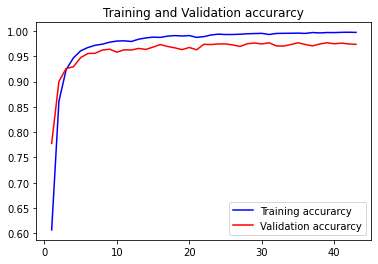

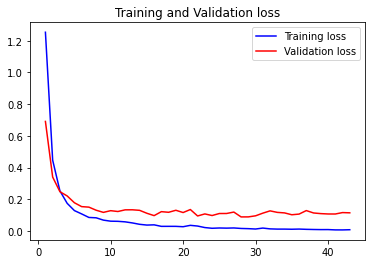

CPU times: user 693 ms, sys: 187 ms, total: 880 ms
Wall time: 631 ms


In [10]:
%%time
temp = pd.DataFrame(history.history)
temp.to_csv('model_xception_history.csv', index=False)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [11]:
print('test images')
for filepath in glob.glob(test_path + '/*/'):
    files = glob.glob(filepath + '*')
    print(f"{len(files)} \t {Path(filepath).name}")
    
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(    
    directory=test_path,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    #classes=['.'],
    #class_mode="categorical",
    class_mode=None,
    shuffle=False,
    seed=SEED)

test images
390 	 tungro
152 	 yellow_stem_borer
431 	 hispa
174 	 downy_mildew
101 	 black_stem_borer
100 	 bacterial_leaf_streak
130 	 bacterial_leaf_blight
253 	 brown_spot
470 	 blast
219 	 leaf_roller
481 	 normal
90 	 bacterial_panicle_blight
254 	 white_stem_borer
Found 3245 images belonging to 13 classes.


In [12]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

model.load_weights('xception.weights.best.hdf5')
pred = model.predict_generator(test_generator,
                               steps=STEP_SIZE_TEST,
                               verbose=1)
pred_classes = np.argmax(pred, axis=1)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3245/3245 [==============================] - 47s 14ms/step


In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

class_names = test_generator.class_indices.keys()
true_classes = test_generator.classes

acc = accuracy_score(true_classes, pred_classes)
print("xception Model Accuracy : {:.2f}%".format(acc * 100))

cls_report = classification_report(true_classes, pred_classes, 
                                   target_names=class_names, digits=5)
print(cls_report)

xception Model Accuracy : 96.58%
                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.95420   0.96154   0.95785       130
   bacterial_leaf_streak    0.94175   0.97000   0.95567       100
bacterial_panicle_blight    0.97727   0.95556   0.96629        90
        black_stem_borer    1.00000   0.91089   0.95337       101
                   blast    0.95607   0.97234   0.96414       470
              brown_spot    0.96078   0.96838   0.96457       253
            downy_mildew    0.93785   0.95402   0.94587       174
                   hispa    0.96454   0.94664   0.95550       431
             leaf_roller    0.99010   0.91324   0.95012       219
                  normal    0.96933   0.98545   0.97732       481
                  tungro    0.98454   0.97949   0.98201       390
        white_stem_borer    0.95437   0.98819   0.97099       254
       yellow_stem_borer    0.96795   0.99342   0.98052       152

                accuracy                 

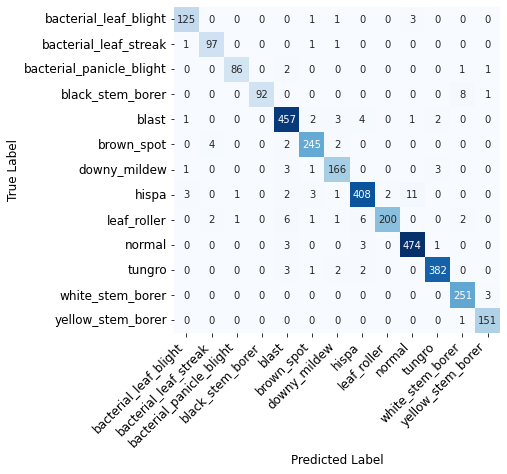

[[125   0   0   0   0   1   1   0   0   3   0   0   0]
 [  1  97   0   0   0   1   1   0   0   0   0   0   0]
 [  0   0  86   0   2   0   0   0   0   0   0   1   1]
 [  0   0   0  92   0   0   0   0   0   0   0   8   1]
 [  1   0   0   0 457   2   3   4   0   1   2   0   0]
 [  0   4   0   0   2 245   2   0   0   0   0   0   0]
 [  1   0   0   0   3   1 166   0   0   0   3   0   0]
 [  3   0   1   0   2   3   1 408   2  11   0   0   0]
 [  0   2   1   0   6   1   1   6 200   0   0   2   0]
 [  0   0   0   0   3   0   0   3   0 474   1   0   0]
 [  0   0   0   0   3   1   2   2   0   0 382   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 251   3]
 [  0   0   0   0   0   0   0   0   0   0   0   1 151]]


In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_generator.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_classes, pred_classes, class_names, ax, title="CNN")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(true_classes, pred_classes)
print(cm)

In [15]:
loss, acc = model.evaluate_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
print(acc, loss)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


3245/3245 [==============================] - 28s 8ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
0.0 0.0


In [16]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_datagen.class_indices)

labels = (train_datagen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

pd.Series(predictions).value_counts()

normal                      489
blast                       478
hispa                       423
tungro                      388
white_stem_borer            263
brown_spot                  255
leaf_roller                 202
downy_mildew                177
yellow_stem_borer           156
bacterial_leaf_blight       131
bacterial_leaf_streak       103
black_stem_borer             92
bacterial_panicle_blight     88
dtype: int64

In [17]:
filenames=test_generator.filenames

results=pd.DataFrame({"image_id":filenames,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


,image_id,label
0,bacterial_leaf_bligh200091.jpg,bacterial_leaf_blight
1,bacterial_leaf_bligh200112.jpg,normal
2,bacterial_leaf_bligh200118.jpg,bacterial_leaf_blight
3,bacterial_leaf_bligh200133.jpg,bacterial_leaf_blight
4,bacterial_leaf_bligh200220.jpg,bacterial_leaf_blight


##### Acknowledgements
  1. https://www.kaggle.com/code/asheniranga/paddy-doctor-training